## Load Library and directories

In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from pylab import *
import json
#import cv2
import h5py
import imageio
from IPython.display import Image
import side
import os

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K 
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
    Activation,
    Conv3D,
    Conv3DTranspose,
    MaxPooling3D,
    UpSampling3D,
)
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

#from tensorflow.compat.v1.logging import INFO, set_verbosity

#set_verbosity(INFO)

K.set_image_data_format("channels_first")

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

physical_device = tf.config.experimental.list_physical_devices('GPU')
print(f'Device found : {physical_device}')

Num GPUs Available:  1
Device found : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
pwd

'c:\\Users\\ad\\Desktop\\JupyterNotebook'

In [3]:
# set home directory and data directory
HOME_DIR = "D:/DataSet/HeadSeg/"
Train_DIR = HOME_DIR + "train/"
Valid_DIR = HOME_DIR + "valid/"
Test_DIR = HOME_DIR + "test/"
DATA_DIR = HOME_DIR
HeadData_DIR = "D:/DataSet/HeadSeg/Raw_HeadSet/"
MRI_DIR = HeadData_DIR + "MRI/"
LABEL_DIR = HeadData_DIR + "Label/"

HOME_DIR = "D:/DataSet/HeadSeg/"


## Load the model

In [4]:
def total_loss(y_true, y_pred, axis = (1, 2, 3), epsilon = 0.00001, gamma=2.0, alpha=0.25):  #combibnational loss with dice loss and focal loss

    """
    Compute mean soft dice loss over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of soft predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator in formula for dice loss.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant added to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_loss (float): computed value of dice loss.     
    """

    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true**2, axis=axis) + K.sum(y_pred**2, axis=axis) + epsilon
    dice_loss = 1 - K.mean((dice_numerator)/(dice_denominator))


    """
    Compute focal loss over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of soft predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator in formula for dice loss.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        alpha: balancing factor, default to be 0.25
        gamma: focusing parameter, default to be 2.0
    Returns:
        focal_loss (float): computed value of dice loss.   
    """
    y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    focal_loss = -K.mean(alpha * K.pow(1.0 - pt, gamma) * K.log(pt), axis=[1,2,3])
    
    total_loss = dice_loss + 1* focal_loss

    return total_loss

def dice_coefficient(y_true, y_pred, axis=(1, 2, 3), 
                     epsilon=0.00001):#epsilon=0.00001
    """
    Compute mean dice coefficient over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator of dice coefficient.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant add to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_coefficient (float): computed value of dice coefficient.     
    """

    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true, axis=axis) + K.sum(y_pred, axis=axis) + epsilon
    dice_coefficient = K.mean((dice_numerator)/(dice_denominator))
 
    return dice_coefficient

In [3]:
def dice_coefficient(y_true, y_pred, axis=(1, 2, 3), 
                     epsilon=0.00001):#epsilon=0.00001
    """
    Compute mean dice coefficient over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator of dice coefficient.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant add to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_coefficient (float): computed value of dice coefficient.     
    """

    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true, axis=axis) + K.sum(y_pred, axis=axis) + epsilon
    dice_coefficient = K.mean((dice_numerator)/(dice_denominator))
 
    return dice_coefficient

def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3), 
                   epsilon=0.00001):#epsilon=0.00001

                   #axis=(1, 2, 3), 
    """
    Compute mean soft dice loss over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of soft predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator in formula for dice loss.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant added to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_loss (float): computed value of dice loss.     
    """

    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true**2, axis=axis) + K.sum(y_pred**2, axis=axis) + epsilon
    dice_loss = 1 - K.mean((dice_numerator)/(dice_denominator))

    return dice_loss

In [5]:
def create_convolution_block(input_layer, n_filters, batch_normalization= False,
                             kernel=(3, 3, 3), activation=None,
                             padding='same', strides=(1, 1, 1),
                             instance_normalization=False):
    """
    :param strides:
    :param input_layer:
    :param n_filters:
    :param batch_normalization:
    :param kernel:
    :param activation: Keras activation layer to use. (default is 'relu')
    :param padding:
    :return:
    """
    layer = Conv3D(n_filters, kernel, padding=padding, strides=strides)(
        input_layer)
    if activation is None:
        return Activation('relu')(layer)
    else:
        return activation()(layer)
    
def get_up_convolution(n_filters, pool_size, kernel_size=(2, 2, 2),
                       strides=(2, 2, 2),
                       deconvolution=False):
    if deconvolution:
        return Conv3DTranspose(filters=n_filters, kernel_size=kernel_size,
                               strides=strides)
    else:
        return UpSampling3D(size=pool_size)

In [6]:
def unet_model_3D(loss_function, input_shape=(1, 80, 80, 64),
                  pool_size=(2, 2, 2), n_labels=5,
                  initial_learning_rate=0.00001,
                  deconvolution=False, depth=4, n_base_filters=32,
                  include_label_wise_dice_coefficients=False, metrics=[],
                  batch_normalization=False, activation_name="sigmoid"): 

    """
    Builds the 3D UNet Keras model.f
    :param metrics: List metrics to be calculated during model training (default is dice coefficient).
    :param include_label_wise_dice_coefficients: If True and n_labels is greater than 1, model will report the dice
    coefficient for each label as metric.
    :param n_base_filters: The number of filters that the first layer in the convolution network will have. Following
    layers will contain a multiple of this number. Lowering this number will likely reduce the amount of memory required
    to train the model.
    :param depth: indicates the depth of the U-shape for the model. The greater the depth, the more max pooling
    layers will be added to the model. Lowering the depth may reduce the amount of memory required for training.
    :param input_shape: Shape of the input data (n_chanels, x_size, y_size, z_size). The x, y, and z sizes must be
    divisible by the pool size to the power of the depth of the UNet, that is pool_size^depth.
    :param pool_size: Pool size for the max pooling operations.
    :param n_labels: Number of binary labels that the model is learning.
    :param initial_learning_rate: Initial learning rate for the model. This will be decayed during training.
    :param deconvolution: If set to True, will use transpose convolution(deconvolution) instead of up-sampling. This
    increases the amount memory required during training.
    :return: Untrained 3D UNet Model
    """
    inputs = Input(input_shape)
    current_layer = inputs
    levels = list()

    # add levels with max pooling
    for layer_depth in range(depth):
        layer1 = create_convolution_block(input_layer=current_layer,
                                          n_filters=n_base_filters * (
                                                  2 ** layer_depth),
                                          batch_normalization=batch_normalization)
        layer2 = create_convolution_block(input_layer=layer1,
                                          n_filters=n_base_filters * (
                                                  2 ** layer_depth) * 2,
                                          batch_normalization=batch_normalization)
        if layer_depth < depth - 1:
            current_layer = MaxPooling3D(pool_size=pool_size)(layer2)
            levels.append([layer1, layer2, current_layer])
        else:
            current_layer = layer2
            levels.append([layer1, layer2])

    # add levels with up-convolution or up-sampling
    for layer_depth in range(depth - 2, -1, -1):
        
        #print(K.int_shape(current_layer)[1])
        up_convolution = get_up_convolution(pool_size=pool_size,
                                            deconvolution=deconvolution,
                                            n_filters=K.int_shape(current_layer)[1])(current_layer)
        
        concat = concatenate([up_convolution, levels[layer_depth][1]], axis=1)
        
        #print(K.int_shape(levels[layer_depth][1])[1])
        current_layer = create_convolution_block(n_filters= K.int_shape(levels[layer_depth][1])[1],
                                                 input_layer=concat, 
                                                 batch_normalization=batch_normalization)
        
        current_layer = create_convolution_block(n_filters= K.int_shape(levels[layer_depth][1])[1],
                                                 input_layer=current_layer,
                                                 batch_normalization=batch_normalization)

    final_convolution = Conv3D(n_labels, (1, 1, 1))(current_layer)
    act = Activation(activation_name)(final_convolution)
    model = Model(inputs=inputs, outputs=act)

    if not isinstance(metrics, list):
        metrics = [metrics]

    model.compile(optimizer=Adam(learning_rate=initial_learning_rate), loss=loss_function,
                  metrics=metrics)
    return model

In [8]:
#model_3D = unet_model_3D(loss_function=soft_dice_loss, metrics=[dice_coefficient])
model_3D = unet_model_3D(depth=4, loss_function=total_loss, metrics=[dice_coefficient])

## Load the trainied weights

In [65]:
from tensorflow.keras.models import load_model
Weights_DIR = HOME_DIR + "weights/Seg_depth4_total_loss/"
weights = model_3D.load_weights(Weights_DIR + "Seg_model_depth4_focal_100epochs.hdf5")

## Load the test set files

In [66]:
TEST_file_list = sorted(os.listdir(Test_DIR))

## Get the order sequence

In [67]:
orig_x = 240
orig_y = 240
orig_z = 192
step_x = 40
step_y = 40
step_z = 32
output_x = 80
output_y = 80
output_z = 64
num_classes = 6

seq=[]
filename = "NIFTI_6.nii"
#filename = "NIFTI_7.nii"

for x in range(0, orig_x-output_x+1, step_x):
    for y in range(0, orig_y-output_y+1, step_y):
        for z in range(0, orig_z-output_z+1, step_z):

            start_x = x
            start_y = y
            start_z = z

            file=filename \
            +"_x_"+str(start_x) \
            +"_y_"+str(start_y) \
            +"_z_"+str(start_z) \
            +"_.h5"

            seq.append(file)

print(len(seq))
for i in range(len(seq)):
    print(seq[i])

125
NIFTI_6.nii_x_0_y_0_z_0_.h5
NIFTI_6.nii_x_0_y_0_z_32_.h5
NIFTI_6.nii_x_0_y_0_z_64_.h5
NIFTI_6.nii_x_0_y_0_z_96_.h5
NIFTI_6.nii_x_0_y_0_z_128_.h5
NIFTI_6.nii_x_0_y_40_z_0_.h5
NIFTI_6.nii_x_0_y_40_z_32_.h5
NIFTI_6.nii_x_0_y_40_z_64_.h5
NIFTI_6.nii_x_0_y_40_z_96_.h5
NIFTI_6.nii_x_0_y_40_z_128_.h5
NIFTI_6.nii_x_0_y_80_z_0_.h5
NIFTI_6.nii_x_0_y_80_z_32_.h5
NIFTI_6.nii_x_0_y_80_z_64_.h5
NIFTI_6.nii_x_0_y_80_z_96_.h5
NIFTI_6.nii_x_0_y_80_z_128_.h5
NIFTI_6.nii_x_0_y_120_z_0_.h5
NIFTI_6.nii_x_0_y_120_z_32_.h5
NIFTI_6.nii_x_0_y_120_z_64_.h5
NIFTI_6.nii_x_0_y_120_z_96_.h5
NIFTI_6.nii_x_0_y_120_z_128_.h5
NIFTI_6.nii_x_0_y_160_z_0_.h5
NIFTI_6.nii_x_0_y_160_z_32_.h5
NIFTI_6.nii_x_0_y_160_z_64_.h5
NIFTI_6.nii_x_0_y_160_z_96_.h5
NIFTI_6.nii_x_0_y_160_z_128_.h5
NIFTI_6.nii_x_40_y_0_z_0_.h5
NIFTI_6.nii_x_40_y_0_z_32_.h5
NIFTI_6.nii_x_40_y_0_z_64_.h5
NIFTI_6.nii_x_40_y_0_z_96_.h5
NIFTI_6.nii_x_40_y_0_z_128_.h5
NIFTI_6.nii_x_40_y_40_z_0_.h5
NIFTI_6.nii_x_40_y_40_z_32_.h5
NIFTI_6.nii_x_40_y_40_z_64_.h5

## Load the MRI subvolumes in sequence, then make prediction on the volumes

In [50]:
#Set threshod function
def threshold(pred):

    # set threshold criteria
    threshold = 0.5

    # use threshold to get hard predictions
    pred_thres=np.zeros(pred.shape)
    pred_thres[pred > threshold] = 1.0
    pred_thres[pred <= threshold] = 0.0

    return pred_thres

In [68]:
pred_label = np.zeros((125, 80, 80, 64))
orig_label = np.zeros((125, 80, 80, 64))
i=0
for file in seq:
    filepath = Test_DIR + file
    with h5py.File(filepath, 'r') as f:
        img = np.array(f.get("x"))
        msk = np.array(f.get("y"))
    
    Test_volume = np.expand_dims(img, axis=0)
    patch_pred = model_3D.predict(Test_volume)
     #Thresholding the prediction result
    pred = threshold(patch_pred)[0, :, :, :, :]

    # create the background volume with all 0s
    background = np.zeros((1, 80, 80, 64))

    #concatenate the volumes along the first dimension with volume2 as the first slice
    pred_con = np.concatenate((background, pred), axis=0)

    #Combine to_catgorical format prediction to a signle volume with class 0~5
    pred_3D = np.argmax(pred_con,axis = 0)

    #Store the prediction volume in array
    pred_label[i, :, :, :] = pred_3D
    
    
    mask = np.concatenate((background, msk), axis=0)
    label_3D = np.argmax(mask, axis = 0)

    orig_label[i, :, :, :] = label_3D
    
    i += 1

print("Done")



1/1 [==============================] - 0s 24ms/step
Done


In [29]:
print(orig_label.shape)
print(pred_label.shape)

(125, 80, 80, 64)
(125, 80, 80, 64)


## Function to define axis corrdination in volume reconstruction

In [69]:
def axis_subvolume(axis, orig, step, output):

    if axis == 0:
        start_coord = axis
        end_coord = output - step/2 
    elif axis == (orig - output):
        start_coord = step/2
        end_coord = output 
    else:
        start_coord = step/2
        end_coord = output -step/2 

    return int(start_coord), int(end_coord)

In [70]:
def axis_coord(axis, orig, step, output):
    if axis == 0:
        start_coord = axis
        end_coord = axis + output - step/2 
    elif axis == (orig - output):
        start_coord = axis + step/2
        end_coord = axis + output 
    else:
        start_coord = axis + step/2
        end_coord = axis + output -step/2 

    return int(start_coord), int(end_coord)

## Test coordination code section, don't need to run when recontruction

In [55]:
orig_label = np.zeros((125, 80, 80, 64))
i=0
for file in seq:
    filepath = Test_DIR + file
    with h5py.File(filepath, 'r') as f:
        img = np.array(f.get("x"))
        msk = np.array(f.get("y"))
    
    # create the background volume with all 0s
    background = np.zeros((1, 80, 80, 64))
    
    
    mask = np.concatenate((background, msk), axis=0)
    label_3D = np.argmax(mask, axis = 0)

    orig_label[i, :, :, :] = label_3D
    
    i += 1

print("Done")

Done


In [56]:
orig_x = 240
orig_y = 240
orig_z = 192
step_x = 40
step_y = 40
step_z = 32
output_x = 80
output_y = 80
output_z = 64

print(seq)

i = np.random.randint(0, 124)
i=124
ax_x = int(seq[i].split("_")[3])
ax_y = int(seq[i].split("_")[5])
ax_z = int(seq[i].split("_")[7])

start_x, end_x = axis_coord(ax_x, orig_x, step_x, output_x)
start_y, end_y = axis_coord(ax_y, orig_y, step_y, output_y)
start_z, end_z = axis_coord(ax_z, orig_z, step_z, output_z)

V_start_x, V_end_x = axis_subvolume(ax_x, orig_x, step_x, output_x)
V_start_y, V_end_y = axis_subvolume(ax_y, orig_y, step_y, output_y)
V_start_z, V_end_z = axis_subvolume(ax_z, orig_z, step_z, output_z)

print(ax_x)
print(ax_y)
print(ax_z)

print(seq[i])
print(f"start_x is: {start_x}, end_x is : {end_x}" )
print(f"start_y is: {start_y}, end_y is : {end_y}" )
print(f"start_z is: {start_z}, end_z is : {end_z}" )

print(f"volume start_x is: {V_start_x}, volume end_x is : {V_end_x}, length is : {(V_end_x-V_start_x+1)}" )
print(f"volume start_y is: {V_start_y}, volume end_y is : {V_end_y}, length is : {(V_end_y-V_start_y+1)}" )
print(f"volume start_z is: {V_start_z}, volume end_z is : {V_end_z}, length is : {(V_end_z-V_start_z+1)}" )

#orig_volume[start_x: start_x + output_x,start_y: start_y + output_y,start_z: start_z + output_z] = test_pred_argmax

['NIFTI_6.nii_x_0_y_0_z_0_.h5', 'NIFTI_6.nii_x_0_y_0_z_32_.h5', 'NIFTI_6.nii_x_0_y_0_z_64_.h5', 'NIFTI_6.nii_x_0_y_0_z_96_.h5', 'NIFTI_6.nii_x_0_y_0_z_128_.h5', 'NIFTI_6.nii_x_0_y_40_z_0_.h5', 'NIFTI_6.nii_x_0_y_40_z_32_.h5', 'NIFTI_6.nii_x_0_y_40_z_64_.h5', 'NIFTI_6.nii_x_0_y_40_z_96_.h5', 'NIFTI_6.nii_x_0_y_40_z_128_.h5', 'NIFTI_6.nii_x_0_y_80_z_0_.h5', 'NIFTI_6.nii_x_0_y_80_z_32_.h5', 'NIFTI_6.nii_x_0_y_80_z_64_.h5', 'NIFTI_6.nii_x_0_y_80_z_96_.h5', 'NIFTI_6.nii_x_0_y_80_z_128_.h5', 'NIFTI_6.nii_x_0_y_120_z_0_.h5', 'NIFTI_6.nii_x_0_y_120_z_32_.h5', 'NIFTI_6.nii_x_0_y_120_z_64_.h5', 'NIFTI_6.nii_x_0_y_120_z_96_.h5', 'NIFTI_6.nii_x_0_y_120_z_128_.h5', 'NIFTI_6.nii_x_0_y_160_z_0_.h5', 'NIFTI_6.nii_x_0_y_160_z_32_.h5', 'NIFTI_6.nii_x_0_y_160_z_64_.h5', 'NIFTI_6.nii_x_0_y_160_z_96_.h5', 'NIFTI_6.nii_x_0_y_160_z_128_.h5', 'NIFTI_6.nii_x_40_y_0_z_0_.h5', 'NIFTI_6.nii_x_40_y_0_z_32_.h5', 'NIFTI_6.nii_x_40_y_0_z_64_.h5', 'NIFTI_6.nii_x_40_y_0_z_96_.h5', 'NIFTI_6.nii_x_40_y_0_z_128_.h5', 'NIF

## Test Reconstruct the Label volume

In [71]:
orig_volume_label = np.zeros((orig_x, orig_y, orig_z))

i=0
for i in range(len(seq)):

    ax_x = int(seq[i].split("_")[3])
    ax_y = int(seq[i].split("_")[5])
    ax_z = int(seq[i].split("_")[7])

    start_x, end_x = axis_coord(ax_x, orig_x, step_x, output_x)
    start_y, end_y = axis_coord(ax_y, orig_y, step_y, output_y)
    start_z, end_z = axis_coord(ax_z, orig_z, step_z, output_z)

    V_start_x, V_end_x = axis_subvolume(ax_x, orig_x, step_x, output_x)
    V_start_y, V_end_y = axis_subvolume(ax_y, orig_y, step_y, output_y)
    V_start_z, V_end_z = axis_subvolume(ax_z, orig_z, step_z, output_z)
    
    orig_volume_label[start_x: end_x, start_y: end_y, start_z: end_z] = orig_label[i, V_start_x :V_end_x, V_start_y :V_end_y, V_start_z :V_end_z]

    #print(seq[i])
    #print(f"start_x is: {start_x}, end_x is : {end_x}" )
    #print(f"start_y is: {start_y}, end_y is : {end_y}" )
    #print(f"start_z is: {start_z}, end_z is : {end_z}" )


5.0
(240, 240, 192)


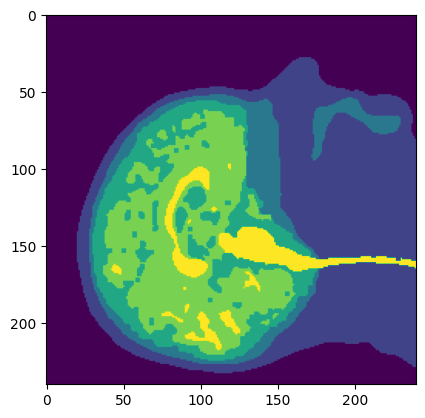

In [58]:
#Check reconstruct volume and plot

print(orig_volume_label.max())
print(orig_volume_label.shape)

index = 100
plt.imshow(orig_volume_label[:,:,index])

## Reconstruct the Volume

In [72]:
orig_volume_label = np.zeros((orig_x, orig_y, orig_z))
orig_volume_pred  = np.zeros((orig_x, orig_y, orig_z))

i=0
for i in range(len(seq)):

    ax_x = int(seq[i].split("_")[3])
    ax_y = int(seq[i].split("_")[5])
    ax_z = int(seq[i].split("_")[7])

    start_x, end_x = axis_coord(ax_x, orig_x, step_x, output_x)
    start_y, end_y = axis_coord(ax_y, orig_y, step_y, output_y)
    start_z, end_z = axis_coord(ax_z, orig_z, step_z, output_z)

    V_start_x, V_end_x = axis_subvolume(ax_x, orig_x, step_x, output_x)
    V_start_y, V_end_y = axis_subvolume(ax_y, orig_y, step_y, output_y)
    V_start_z, V_end_z = axis_subvolume(ax_z, orig_z, step_z, output_z)
    
    orig_volume_pred[start_x: end_x, start_y: end_y, start_z: end_z] = pred_label[i, V_start_x :V_end_x, V_start_y :V_end_y, V_start_z :V_end_z]
    orig_volume_label[start_x: end_x, start_y: end_y, start_z: end_z] = orig_label[i, V_start_x :V_end_x, V_start_y :V_end_y, V_start_z :V_end_z]


5.0
(240, 240, 192)


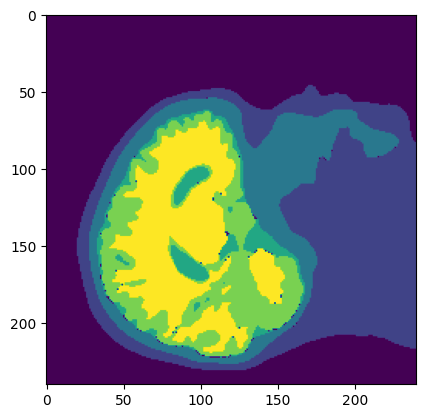

In [60]:
#Check reconstruct volume and plot

print(orig_volume_pred.max())
print(orig_volume_pred.shape)

index = 80
plt.imshow(orig_volume_pred[:,:,index])

## Calculate Accuracy

## Using built in keras function for IoU

Mean Intersection-Over-Union is a common evaluation metric for semantic image segmentation, which first computes the IOU for each semantic class and then computes the average over classes. 

IOU is defined as follows: IOU = true_positive / (true_positive + false_positive + false_negative). 

The predictions are accumulated in a confusion matrix, weighted by sample_weight and the metric is then calculated from it.

In [73]:
from keras.metrics import MeanIoU

test_mask_argmax = orig_volume_label
test_pred_argmax = orig_volume_pred

n_classes = 6
IOU_keras = MeanIoU(num_classes= n_classes)
IOU_keras.update_state(test_mask_argmax, test_pred_argmax)
print("Overall Mean IoU(Accuracy) = ", IOU_keras.result().numpy())

Tissue = ["Background", "Skin", "Skull", "CSF", "GM", "WM"] 

for i in range(1, 6):
    IOU_keras.reset_states()
    class_mask = np.equal(test_mask_argmax, i)
    class_pred = np.equal(test_pred_argmax, i)
    IOU_keras.update_state(class_mask, class_pred)
    print(f"{Tissue[i]} IoU(Accuracy) = "  ,IOU_keras.result().numpy())

Overall Mean IoU(Accuracy) =  0.755146
Skin IoU(Accuracy) =  0.9583671
Skull IoU(Accuracy) =  0.7846901
CSF IoU(Accuracy) =  0.7063062
GM IoU(Accuracy) =  0.8786646
WM IoU(Accuracy) =  0.89449716


## Plot Prediction result

In [74]:
num_classes = 6

path = "D:/DataSet/HeadSeg/Raw_HeadSet/MRI/NIFTI_7.nii"
img=np.array(nib.load(path).get_fdata())
img_scale=scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)

#Reshape to 240x240x192
image = img_scale[0:240, 5:245, :]

truth = keras.utils.to_categorical(orig_volume_label, num_classes = 6)
predict_label = keras.utils.to_categorical(orig_volume_pred, num_classes = 6)

truth = np.moveaxis(truth, 3, 0)
predict_label = np.moveaxis(predict_label, 3, 0)

In [75]:
print(image.max())
print(truth.shape)
print(predict_label.shape)

1.0
(6, 240, 240, 192)
(6, 240, 240, 192)


index on xy plane: 80


Text(0.5, 1.0, 'White Matter_Prediction')

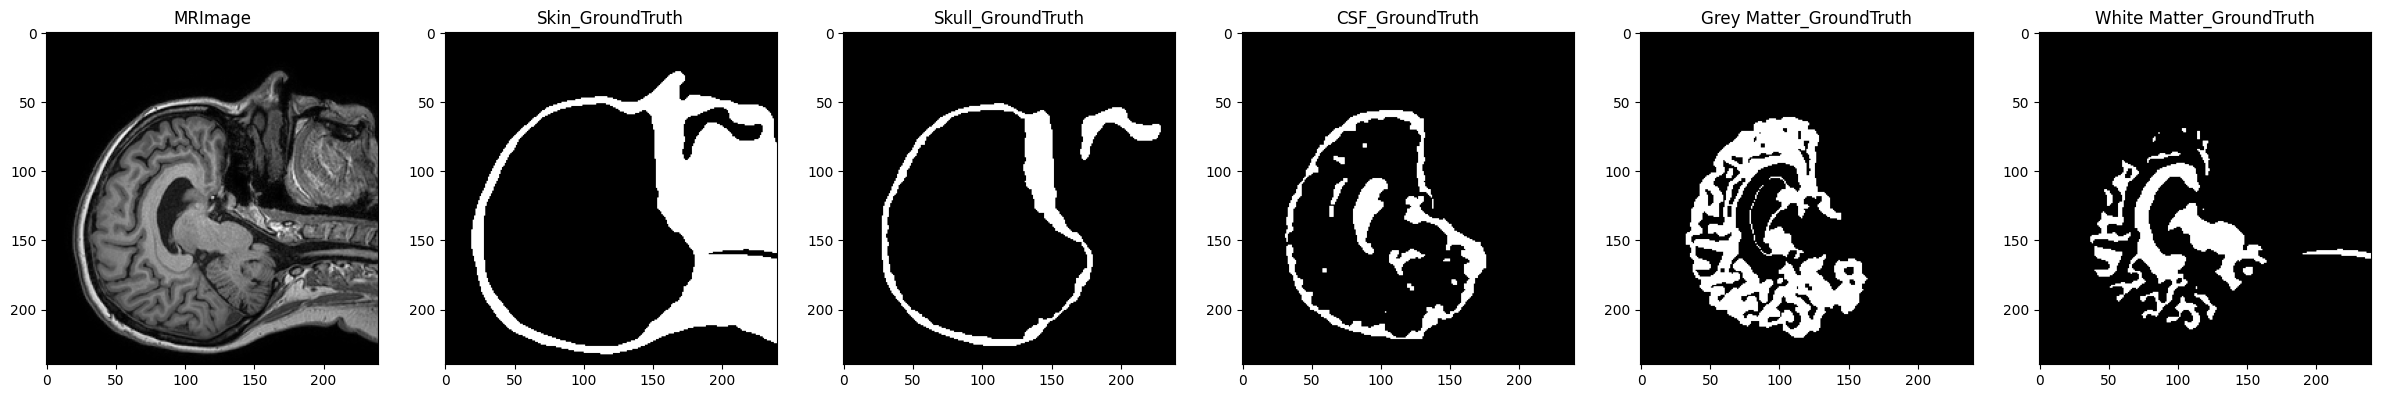

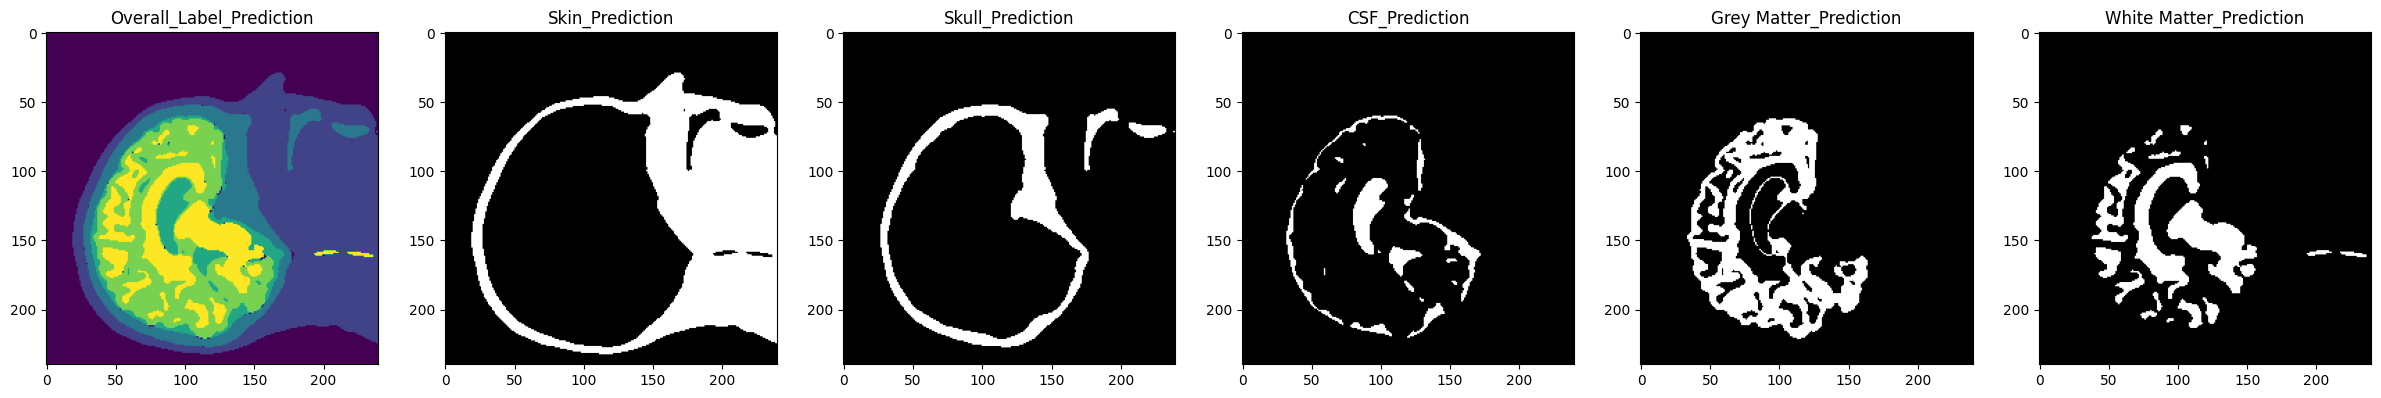

In [76]:
i = np.random.randint(0,191)
i = 90
print(f"index on xy plane: {index}")

fig, ax = plt.subplots(1, 6, figsize=[30, 30], squeeze=False)
ax[0][0].imshow(image[: ,:, i], cmap='Greys_r')
ax[0][0].set_title("MRImage")

ax[0][1].imshow(truth[1, :, :, i], cmap='Greys_r')
ax[0][1].set_title("Skin_GroundTruth")

ax[0][2].imshow(truth[2, :, :, i], cmap='Greys_r')
ax[0][2].set_title("Skull_GroundTruth")

ax[0][3].imshow(truth[3, :, :, i], cmap='Greys_r')
ax[0][3].set_title("CSF_GroundTruth")

ax[0][4].imshow(truth[4, :, :, i], cmap='Greys_r')
ax[0][4].set_title("Grey Matter_GroundTruth")

ax[0][5].imshow(truth[5, :, :, i], cmap='Greys_r')
ax[0][5].set_title("White Matter_GroundTruth")


fig, ax = plt.subplots(1, 6, figsize=[30, 30], squeeze=False)
ax[0][0].imshow(orig_volume_pred[: ,:, i])
ax[0][0].set_title("Overall_Label_Prediction")

ax[0][1].imshow(predict_label[1, :, :, i], cmap='Greys_r')
ax[0][1].set_title("Skin_Prediction")

ax[0][2].imshow(predict_label[2, :, :, i], cmap='Greys_r')
ax[0][2].set_title("Skull_Prediction")

ax[0][3].imshow(predict_label[3, :, :, i], cmap='Greys_r')
ax[0][3].set_title("CSF_Prediction")

ax[0][4].imshow(predict_label[4, :, :, i], cmap='Greys_r')
ax[0][4].set_title("Grey Matter_Prediction")

ax[0][5].imshow(predict_label[5, :, :, i], cmap='Greys_r')
ax[0][5].set_title("White Matter_Prediction")

## Save the prediction as NIFTI(.nii) file


In [77]:
import nibabel as nib
#head = nib.Nifti1Image(Image, affine= None)
nii = nib.Nifti1Image(orig_volume_pred, affine= None)

#nib.save(head, 'fixed_headMRI_7.nii')
nib.save(nii, 'depth4_total_loss_prediction.nii')

In [78]:
## Save as ndarry file type

import numpy as np
  
np.save('depth4_total_loss_prediction.npy', orig_volume_pred)
  

## Save the label as NIFTI(.nii) file

In [79]:
import nibabel as nib
#head = nib.Nifti1Image(Image, affine= None)
nii = nib.Nifti1Image(orig_volume_label, affine= None)

#nib.save(head, 'fixed_headMRI_7.nii')
nib.save(nii, 'depth4_total_loss_label.nii')

In [80]:
## Save as ndarry file type

import numpy as np
  
np.save('depth4_total_loss_label.npy', orig_volume_pred)

## Save MRI in shape(240,240,192), don't run if unnecessary

In [45]:
path = "D:/DataSet/HeadSeg/origin/Head_datasets/NIFTI_7.nii"
img=np.array(nib.load(path).get_fdata())

#Reshape to 240x240x192
image = img[0:240, 5:245, :]


In [24]:
print(image.shape)
print(image.max())

(240, 240, 192)
3451.0


In [25]:
head = nib.Nifti1Image(image, affine= None)

nib.save(head, 'fixed_headMRI_7.nii')

## Exam nifti data

In [46]:
img=np.array(nib.load("fixed_headMRI_7.nii").get_fdata())
print(img.max())

3451.0


## Segment according to ground truth

In [47]:
print(orig_volume_label.max())
img.shape

5.0


(240, 240, 192)

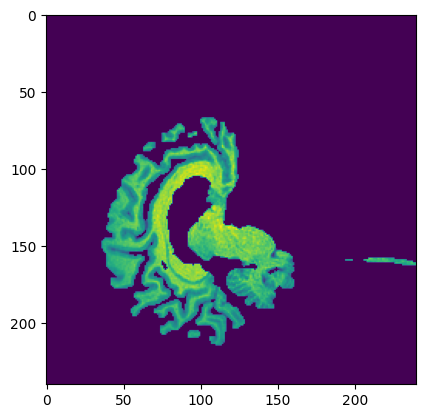

In [56]:
Skin_truth = np.zeros(img.shape)
Skull_truth = np.zeros(img.shape)
CSF_truth = np.zeros(img.shape)
GM_truth = np.zeros(img.shape)
WM_truth = np.zeros(img.shape)

Skin_truth[orig_volume_label==1] = img[orig_volume_label==1]
Skull_truth[orig_volume_label==2] = img[orig_volume_label==2]
CSF_truth[orig_volume_label==3] = img[orig_volume_label==3]
GM_truth[orig_volume_label==4] = img[orig_volume_label==4]
WM_truth[orig_volume_label==5] = img[orig_volume_label==5]
i=90
plt.imshow(WM_truth[:,:,i])

In [63]:
MRI_1_skin = nib.Nifti1Image(Skin_truth, affine= None)
MRI_2_skull = nib.Nifti1Image(Skull_truth, affine= None)
MRI_3_csf = nib.Nifti1Image(CSF_truth, affine= None)
MRI_4_GM = nib.Nifti1Image(GM_truth, affine= None)
MRI_5_WM = nib.Nifti1Image(WM_truth, affine= None)

nib.save(MRI_1_skin, 'MRI_1_skin.nii')
nib.save(MRI_2_skull, 'MRI_2_skull.nii')
nib.save(MRI_3_csf, 'MRI_3_csf.nii')
nib.save(MRI_4_GM, 'MRI_4_GM.nii')
nib.save(MRI_5_WM, 'MRI_5_WM.nii')

3306.0


In [60]:
path = "D:/DataSet/HeadSeg/MOdel/Model_depth4_DataAug_total_loss.nii"

orig_volume_pred =np.array(nib.load(path).get_fdata())

#Reshape to 240x240x192
#image = img[0:240, 5:245, :]

orig_volume_pred.shape

(240, 240, 192)

In [61]:
Skin_pred = np.zeros(img.shape)
Skull_pred = np.zeros(img.shape)
CSF_pred = np.zeros(img.shape)
GM_pred = np.zeros(img.shape)
WM_pred = np.zeros(img.shape)

Skin_pred[orig_volume_pred==1] = img[orig_volume_pred==1]
Skull_pred[orig_volume_pred==2] = img[orig_volume_pred==2]
CSF_pred[orig_volume_pred==3] = img[orig_volume_pred==3]
GM_pred[orig_volume_pred==4] = img[orig_volume_pred==4]
WM_pred[orig_volume_pred==5] = img[orig_volume_pred==5]

In [62]:
pred_1_skin = nib.Nifti1Image(Skin_pred, affine= None)
pred_2_skull = nib.Nifti1Image(Skull_pred, affine= None)
pred_3_csf = nib.Nifti1Image(CSF_pred, affine= None)
pred_4_GM = nib.Nifti1Image(GM_pred, affine= None)
pred_5_WM = nib.Nifti1Image(WM_pred, affine= None)

nib.save(pred_1_skin, 'pred_1_skin.nii')
nib.save(pred_2_skull, 'pred_2_skull.nii')
nib.save(pred_3_csf, 'pred_3_csf.nii')
nib.save(pred_4_GM, 'pred_4_GM.nii')
nib.save(pred_5_WM, 'pred_5_WM.nii')